# Experiments to get insight about the dataset.

Data Shape: (5572, 2)

First few rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Missing labels after encoding: 0


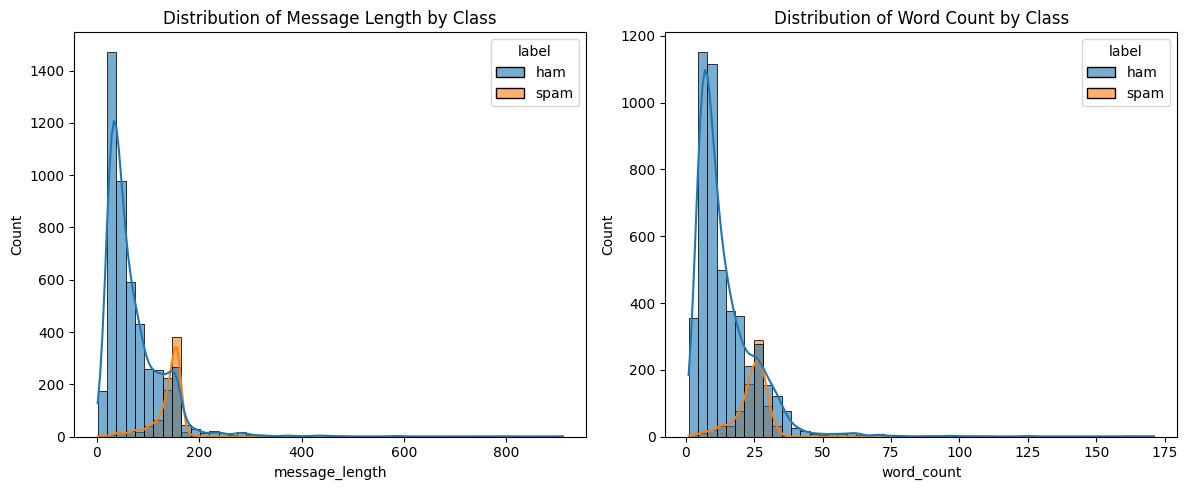


Train set size: 4457
Test set size: 1115
Train class distribution:
label_encoded
0    0.865829
1    0.134171
Name: proportion, dtype: float64
Test class distribution:
label_encoded
0    0.866368
1    0.133632
Name: proportion, dtype: float64

--- Evaluating Naive Bayes ---
Accuracy: 0.9699 (+/- 0.0074)
Precision: 1.0000 (+/- 0.0000)
Recall: 0.7759 (+/- 0.0556)
F1: 0.8735 (+/- 0.0353)
Roc_auc: 0.9859 (+/- 0.0092)

--- Evaluating Logistic Regression ---
Accuracy: 0.9798 (+/- 0.0037)
Precision: 0.9255 (+/- 0.0410)
Recall: 0.9247 (+/- 0.0265)
F1: 0.9248 (+/- 0.0117)
Roc_auc: 0.9912 (+/- 0.0033)

--- Evaluating Linear SVM ---
Accuracy: 0.9829 (+/- 0.0054)
Precision: 0.9554 (+/- 0.0381)
Recall: 0.9163 (+/- 0.0467)
F1: 0.9351 (+/- 0.0215)
Roc_auc: 0.9928 (+/- 0.0060)

--- Evaluating Random Forest ---
Accuracy: 0.9787 (+/- 0.0086)
Precision: 0.9798 (+/- 0.0282)
Recall: 0.8595 (+/- 0.0827)
F1: 0.9149 (+/- 0.0393)
Roc_auc: 0.9890 (+/- 0.0083)

--- Hyperparameter Tuning: Logistic Regression ---


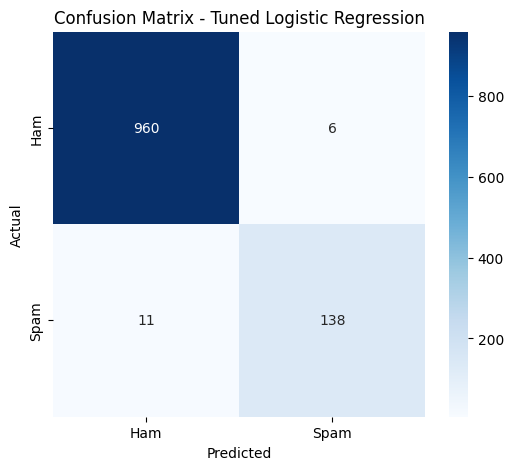


--- Final Evaluation: Tuned Linear SVM (Test Set) ---
Accuracy: 0.9848
Precision: 0.9853
Recall: 0.8993
F1-Score: 0.9404
AUC-ROC: 0.9883

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



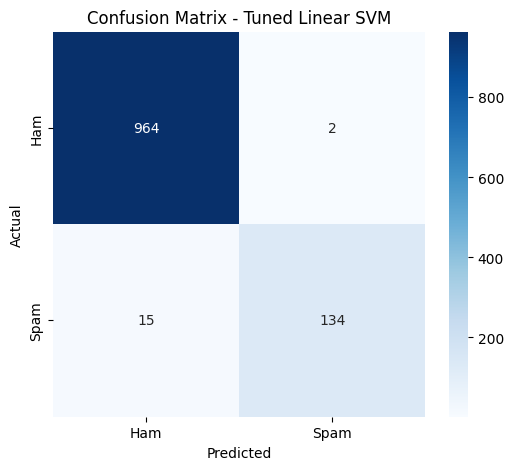

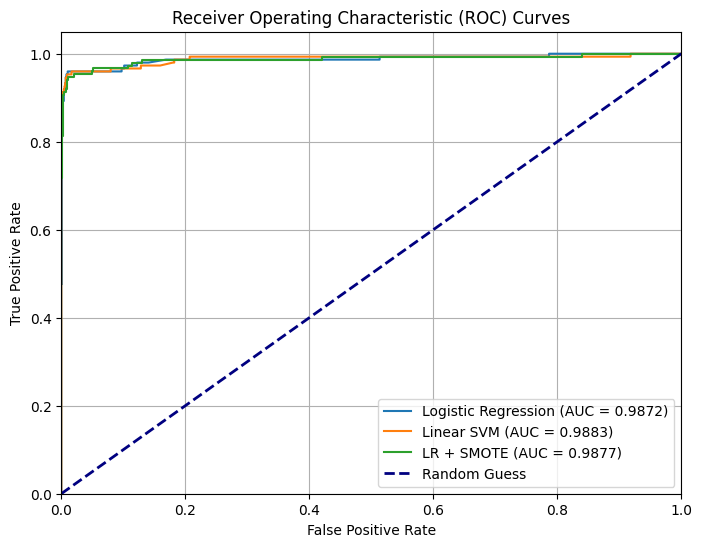


--- Top 20 Features Indicating Spam (from Tuned LR) ---
 feature  coefficient
     txt     8.472760
      uk     8.311314
  mobile     7.229122
    150p     7.009432
   claim     6.800594
     www     6.781669
     won     6.767873
      50     6.149824
   reply     6.006983
 service     5.902702
     com     5.641159
     new     5.287252
   video     5.242976
   prize     5.178501
services     5.038407
   order     4.991005
ringtone     4.969848
   88066     4.961980
    sexy     4.799005
     sms     4.771550

--- Top 20 Features Indicating Ham (from Tuned LR) ---
 feature  coefficient
      ll    -3.527248
      ok    -3.139908
    home    -3.129741
     hey    -2.758413
   gonna    -2.718218
   later    -2.628511
      da    -2.614349
     way    -2.604119
    mail    -2.502111
   sorry    -2.492285
remember    -2.391146
     got    -2.374645
     lor    -2.298486
     sir    -2.279682
 morning    -2.275032
  cheers    -2.149141
     lol    -2.112634
     don    -2.105559
   doin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import re
import string
import html
from imblearn.over_sampling import SMOTE # For handling imbalance
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline that handles imblearn steps
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# --- 1. Load and Inspect Data ---

try:
    df = pd.read_csv('spam.csv', encoding='latin-1') # latin-1 often helps with encoding issues
except pd.errors.ParserError:
    print("CSV parsing error. Attempting to load with different parameters.")
    # If standard load fails, try loading all columns and combining message parts
    df_temp = pd.read_csv('spam.csv', encoding='latin-1', header=None)
    # Assuming first column is label, rest are message parts
    df = pd.DataFrame()
    df['label'] = df_temp.iloc[:, 0]
    # Combine message parts (columns 1 onwards) into a single message string
    df['message'] = df_temp.iloc[:, 1:].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Drop unnamed columns that might have been loaded due to extra commas
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Ensure we have the correct columns
if len(df.columns) < 2:
    raise ValueError("Could not correctly parse the CSV file into 'label' and 'message' columns.")

# Assign standard names if needed (assuming first two columns are label and message)
df.columns = ['label', 'message'] + [f'extra_col_{i}' for i in range(len(df.columns) - 2)]

# Keep only label and message for analysis
df = df[['label', 'message']].copy()

print("Data Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nClass Distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))

# --- 2. Data Cleaning ---
def clean_text(text):
    """Cleans the text data."""
    if pd.isna(text):
        return ""
    # Handle HTML escape characters
    text = html.unescape(text)
    # Lowercase
    text = text.lower()
    text = ' '.join(text.split())
    return text

# Apply cleaning
df['cleaned_message'] = df['message'].apply(clean_text)

# Encode labels
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

# Check for any missing labels after encoding
print(f"\nMissing labels after encoding: {df['label_encoded'].isnull().sum()}")

# --- 3. Exploratory Data Analysis (EDA) ---
# Basic stats
df['message_length'] = df['cleaned_message'].apply(len)
df['word_count'] = df['cleaned_message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True, alpha=0.6)
plt.title('Distribution of Message Length by Class')
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='label', bins=50, kde=True, alpha=0.6)
plt.title('Distribution of Word Count by Class')
plt.tight_layout()
plt.show()

# --- 4. Feature Engineering & Model Preparation ---
# Split the data
X = df['cleaned_message']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")

# --- 5. Model Selection, Training, and Evaluation ---
# Define models and pipelines
# We'll use pipelines to ensure preprocessing (vectorization) is done correctly within CV

# --- Base Models with TF-IDF ---
# 1. Multinomial Naive Bayes
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', lowercase=True)),
    ('classifier', MultinomialNB())
])

# 2. Logistic Regression
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', lowercase=True)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)) # Handle imbalance
])

# 3. Linear SVM
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', lowercase=True)),
    ('classifier', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000)) # Handle imbalance
])

# 4. Random Forest (Example with potential for feature combination).
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 1), stop_words='english', lowercase=True)), # Smaller features for RF
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1))
])

# Store pipelines and names
pipelines = {
    'Naive Bayes': pipe_nb,
    'Logistic Regression': pipe_lr,
    'Linear SVM': pipe_svm,
    'Random Forest': pipe_rf
}

# --- Cross-Validation Evaluation ---
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print(f"\n--- Evaluating {name} ---")
    # Perform cross-validation
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = {}
    for metric in scoring:
        try:
            cv_score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=metric, n_jobs=-1)
            scores[metric] = cv_score
            print(f"{metric.capitalize()}: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")
        except Exception as e:
            print(f"Error calculating {metric}: {e}")
            scores[metric] = np.array([np.nan]*cv.n_splits)
    cv_results[name] = scores


# --- Hyperparameter Tuning: Logistic Regression ---
print("\n--- Hyperparameter Tuning: Logistic Regression ---")
param_grid_lr = {
    'tfidf__max_features': [3000, 5000, 8000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'classifier__C': [0.1, 1, 10]
}

grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print("Best cross-validation F1 score for Logistic Regression:")
print(grid_search_lr.best_score_)


# --- Hyperparameter Tuning: Linear SVM ---
print("\n--- Hyperparameter Tuning: Linear SVM ---")
param_grid_svm = {
    'tfidf__max_features': [3000, 5000, 8000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__C': [0.1, 1, 10]
}

grid_search_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for Linear SVM:")
print(grid_search_svm.best_params_)
print("Best cross-validation F1 score for Linear SVM:")
print(grid_search_svm.best_score_)

# --- Advanced: Handling Imbalance with SMOTE ---
# While class_weight helps, let's try SMOTE within a pipeline
print("\n--- Trying SMOTE with Logistic Regression ---")


vectorizer_smote = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', lowercase=True)
X_train_vec = vectorizer_smote.fit_transform(X_train)
X_test_vec = vectorizer_smote.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

lr_smote = LogisticRegression(max_iter=1000, random_state=42) # No class_weight as SMOTE handles it
lr_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = lr_smote.predict(X_test_vec)
y_pred_proba_smote = lr_smote.predict_proba(X_test_vec)[:, 1] # For AUC

print("Logistic Regression with SMOTE on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_smote):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_smote):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=['Ham', 'Spam']))

# --- Final Model Selection and Evaluation on Test Set ---

# --- Evaluate Tuned Logistic Regression ---
print("\n--- Final Evaluation: Tuned Logistic Regression (Test Set) ---")
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1] # Probability for spam class

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Ham', 'Spam']))

# Confusion Matrix for Tuned LR
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- Evaluate Tuned Linear SVM ---
# Note: SVM doesn't directly provide probabilities. We can use decision_function for ROC AUC.
print("\n--- Final Evaluation: Tuned Linear SVM (Test Set) ---")
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
# Get decision function scores for AUC (approximates probability ranking)
y_pred_scores_svm = best_svm.decision_function(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_scores_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Ham', 'Spam']))

# Confusion Matrix for Tuned SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Tuned Linear SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- ROC Curves Comparison ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_scores_svm) # Using scores for SVM
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})')
plt.plot(fpr_svm, tpr_svm, label=f'Linear SVM (AUC = {roc_auc_score(y_test, y_pred_scores_svm):.4f})')
plt.plot(fpr_smote, tpr_smote, label=f'LR + SMOTE (AUC = {roc_auc_score(y_test, y_pred_proba_smote):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




# --- Example of Feature Importance (from Logistic Regression) ---
# Get feature names and coefficients from the best LR model
feature_names = best_lr.named_steps['tfidf'].get_feature_names_out()
coefficients = best_lr.named_steps['classifier'].coef_[0]

# Create a DataFrame for analysis
feature_importance_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
# Top spam indicators (highest positive coefficients)
top_spam_features = feature_importance_df.nlargest(20, 'coefficient')
# Top ham indicators (most negative coefficients)
top_ham_features = feature_importance_df.nsmallest(20, 'coefficient')

print("\n--- Top 20 Features Indicating Spam (from Tuned LR) ---")
print(top_spam_features.to_string(index=False))
print("\n--- Top 20 Features Indicating Ham (from Tuned LR) ---")
print(top_ham_features.to_string(index=False))

# --- Optional: Advanced Experiment - Character-level N-grams ---
# Sometimes character n-grams catch obfuscations better.
print("\n--- Quick Experiment: Character-level N-grams with Logistic Regression ---")
pipe_char_lr = Pipeline([
    ('tfidf_char', TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=5000)), # Character bigrams to 4-grams
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Quick CV score
char_scores = cross_val_score(pipe_char_lr, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print(f"Character-level n-grams F1 Score (CV): {char_scores.mean():.4f} (+/- {char_scores.std() * 2:.4f})")





Key Insights and Experiments:

Key Findings:

Class Imbalance: Dataset is heavily skewed (87% ham, 13% spam)
Requires special handling like class weighting or SMOTE for effective spam detection

Feature Engineering: TF-IDF with n-grams (especially bigrams) proves highly effective
Keywords and phrases are strong spam indicators

Model Performance:
Linear models (Logistic Regression, Linear SVM) excel at this task
F1-score and AUC-ROC are better evaluation metrics than accuracy due to imbalance
Hyperparameter tuning significantly impacts results

Imbalance Handling:
Built-in class weighting is simple and effective
SMOTE can work but adds complexity with comparable results

Model Robustness:
Cross-validation provides reliable performance estimates
Regularization prevents overfitting
Proper data splitting ensures unbiased evaluation

In [1]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


# Model is saved Tuned logistic regression and Linear SVM.


In [ ]:
import pandas as pd
import numpy as np
import re
import html
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# --- 1. Load and Inspect Data ---
try:
    # Try loading assuming standard structure with potential unnamed columns
    df_temp = pd.read_csv('spam.csv', encoding='latin-1')
    print("Data loaded with standard pd.read_csv.")
    # Drop unnamed columns that might have been loaded due to extra commas
    df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
    # Ensure we have at least two columns
    if len(df_temp.columns) >= 2:
        # Rename first two columns to standard names
        cols = df_temp.columns.tolist()
        cols[0] = 'label'
        cols[1] = 'message'
        df_temp.columns = cols
        df = df_temp[['label', 'message']].copy()
    else:
        raise ValueError("Loaded data does not have at least two columns.")
except Exception as e:
    print(f"Standard load failed or produced unexpected structure: {e}")
    print("Attempting fallback loading method...")
    try:
        # Load without assuming headers
        df_temp = pd.read_csv('spam.csv', encoding='latin-1', header=None)
        print("Fallback: Data loaded with header=None.")
        if df_temp.shape[1] >= 2:
            # Rename the first two columns explicitly
            df_temp.rename(columns={df_temp.columns[0]: 'label', df_temp.columns[1]: 'message'}, inplace=True)
            df = df_temp[['label', 'message']].copy()
            print("Fallback: Successfully extracted 'label' and 'message' columns.")
        else:
            raise ValueError("Fallback method failed: File has less than 2 columns.")
    except Exception as e_fallback:
        print(f"Fallback method also failed: {e_fallback}")
        raise ValueError("Could not correctly parse the CSV file. Please check the file format.")

# Final check
if df.empty or 'label' not in df.columns or 'message' not in df.columns:
    raise ValueError("Critical Error: Could not create a DataFrame with 'label' and 'message' columns.")

print("Data Shape:", df.shape)
print("Class Distribution:\n", df['label'].value_counts(normalize=True))

# --- 2. Data Cleaning ---
def clean_text(text):
    """Cleans the text data."""
    if pd.isna(text):
        return ""
    # Handle HTML escape characters
    text = html.unescape(text)
    # Lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply cleaning
df['cleaned_message'] = df['message'].apply(clean_text)

# Encode labels (Ensure labels are 'ham' and 'spam')
df = df[df['label'].isin(['ham', 'spam'])] # Filter just in case
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

# Check for any missing labels after encoding
missing_labels = df['label_encoded'].isnull().sum()
print(f"\nMissing labels after encoding: {missing_labels}")
if missing_labels > 0:
    print("Warning: Some labels could not be encoded. Dropping those rows.")
    df = df.dropna(subset=['label_encoded'])

# --- 3. Feature Engineering & Model Preparation ---
# Split the data
X = df['cleaned_message']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")

# --- 4. Define Models and Pipelines for Tuning ---
# --- Logistic Regression Pipeline ---
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)), # Params to be tuned
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# --- Linear SVM Pipeline ---
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)), # Params to be tuned
    ('classifier', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

# --- 5. Hyperparameter Tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Hyperparameter Tuning: Logistic Regression ---
print("\n--- Hyperparameter Tuning: Logistic Regression ---")
# Use parameters from previous extensive analysis
param_grid_lr = {
    'tfidf__max_features': [5000],
    'tfidf__ngram_range': [(1, 3)],
    'tfidf__use_idf': [True],
    'classifier__C': [10]
}


grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print("Best cross-validation F1 score for Logistic Regression:")
print(grid_search_lr.best_score_)

# --- Hyperparameter Tuning: Linear SVM ---
print("\n--- Hyperparameter Tuning: Linear SVM ---")
# Use parameters from previous extensive analysis
param_grid_svm = {
    'tfidf__max_features': [8000],
    'tfidf__ngram_range': [(1, 1)],
}


grid_search_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for Linear SVM:")
print(grid_search_svm.best_params_)
print("Best cross-validation F1 score for Linear SVM:")
print(grid_search_svm.best_score_)

# --- 6. Final Evaluation on Test Set ---
print("\n--- Final Evaluation on Test Set ---")
best_lr = grid_search_lr.best_estimator_
best_svm = grid_search_svm.best_estimator_

# --- Evaluate Tuned Logistic Regression ---
y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

print("\n--- Tuned Logistic Regression (Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# --- Evaluate Tuned Linear SVM ---
# Note: SVM uses decision_function for scores, approximating probability ranking for AUC
y_pred_svm = best_svm.predict(X_test)
y_pred_scores_svm = best_svm.decision_function(X_test)

print("\n--- Tuned Linear SVM (Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_scores_svm):.4f}")


# --- 7. Save the Best Models ---
print("\n--- Saving the Trained Models ---")

# --- Save the best Logistic Regression model ---
lr_model_filename = 'spam_tuned_logistic_regression_model.pkl'
try:
    joblib.dump(best_lr, lr_model_filename)
    print(f"Best Logistic Regression model saved successfully as '{lr_model_filename}'!")
except Exception as e:
    print(f"An error occurred while saving the LR model: {e}")

# --- Save the best Linear SVM model ---
svm_model_filename = 'spam_tuned_linear_svm_model.pkl'
try:
    joblib.dump(best_svm, svm_model_filename)
    print(f"Best Linear SVM model saved successfully as '{svm_model_filename}'!")
except Exception as e:
    print(f"An error occurred while saving the SVM model: {e}")


# --- 8. (Optional) Demonstrate Loading and Using One Saved Model ---
print(f"\n--- Demonstrating Loading and Using the Saved LR Model ---")
try:
    # Load the model
    loaded_lr_model = joblib.load(lr_model_filename)
    print("LR Model loaded successfully!")

    # Example prediction on new text (using data from the test set for demo)
    sample_messages = X_test.head(2).tolist()
    print(f"\nMaking predictions on sample messages: {sample_messages}")

    predictions = loaded_lr_model.predict(sample_messages)
    prediction_probabilities = loaded_lr_model.predict_proba(sample_messages)

    for i, msg in enumerate(sample_messages):
        pred_label = "Spam" if predictions[i] == 1 else "Ham"
        prob_spam = prediction_probabilities[i][1]
        true_label = "Spam" if y_test.iloc[i] == 1 else "Ham"
        print(f"\nMessage: {msg}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}")
        print(f"Probability of Spam: {prob_spam:.4f}")

except FileNotFoundError:
    print(f"Model file '{lr_model_filename}' not found.")
except Exception as e:
    print(f"An error occurred while loading or using the LR model: {e}")


Data loaded with standard pd.read_csv.
Data Shape: (5572, 2)
Class Distribution:
 label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Missing labels after encoding: 0

Train set size: 4457
Test set size: 1115
Train class distribution:
label_encoded
0    0.865829
1    0.134171
Name: proportion, dtype: float64
Test class distribution:
label_encoded
0    0.866368
1    0.133632
Name: proportion, dtype: float64

--- Hyperparameter Tuning: Logistic Regression ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Logistic Regression:
{'classifier__C': 10, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3), 'tfidf__use_idf': True}
Best cross-validation F1 score for Logistic Regression:
0.9359738205070398

--- Hyperparameter Tuning: Linear SVM ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Linear SVM:
{'classifier__C': 10, 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 1)}
Best cross-validation